<a></a>
# 1. Introduction

The current project is based on the project on [Datacamp](https://www.datacamp.com/projects/184) with data from the mobile game Cookie Cats.

The project analyzes whether to change the place of a first gate in the game where players are forced to either wait some time before they can progress or make an in-app purchase. Results come from the experiment of moving the gate from level 30 to level 40. The metric for evaluation would be player retention. Related data were collected for unique userids who have been assigned to the two groups.

The hypothesis is by moving the gate back by 10 levels, player retention would change. The specific metrics for evaluating player retention is whether players come back after 1 and 7 days.

<a></a>

# 2. An overview of the data

## 2.1 Info on the dataset

In [110]:
library(tidyverse)
df <- read_csv('datasets/cookie_cats.csv')
head(df)

Parsed with column specification:
cols(
  userid = col_double(),
  version = col_character(),
  sum_gamerounds = col_double(),
  retention_1 = col_logical(),
  retention_7 = col_logical()
)


userid,version,sum_gamerounds,retention_1,retention_7
<dbl>,<chr>,<dbl>,<lgl>,<lgl>
116,gate_30,3,FALSE,FALSE
337,gate_30,38,TRUE,FALSE
377,gate_40,165,TRUE,FALSE
483,gate_40,1,FALSE,FALSE
488,gate_40,179,TRUE,TRUE
540,gate_40,187,TRUE,TRUE


In [111]:
# missing values
cat('number of missing values in the dataset:', sum(is.na(df)), '\n')
# total observations
cat('total number of observations:', nrow(df), '\n')
# number of unique user ids
cat('total number of unique users:', length(unique(df$userid)), '\n')
# number of observations in each group
cat('number of observations in each group:')
df %>% group_by(version) %>% summarise(number = n())

number of missing values in the dataset: 0 
total number of observations: 90189 
total number of unique users: 90189 
number of observations in each group:

version,number
<chr>,<int>
gate_30,44700
gate_40,45489


The dataset consists of observations of 90,189 users that installed the game while the test was running. It has 5 columns:
* <code>userid</code> - unit of diversion.
* <code>version</code> - variable for the test; <code>gate_30</code> for users in the control group, <code>gate_40</code> for users in the experiment group.
* <code>sum_gamerounds</code> - the number of game rounds played by the user during the first week after installation.
* <code>retention_1</code> - did the player come back and play 1 day after installing?
* <code>retention_7</code> - did the player come back and play 7 days after installing?</li>

The table above shows the number of users in the respective groups:
there are 44,700 users in the control group and 45,489 users in the experiment group.

Here we run a sanity check to see if the number of people in the 2 groups are comparable by calculating the 95% confidence interval for the number of users in each group based on $p = 0.5$

In [112]:
p <- 0.5
n <- nrow(df)
z_score <- qnorm(1-0.05/2)
cat('The 95% CI for the number of samples in each group given p=0.5 is (', 
    n*p - z_score*sqrt(p*(1-p)/n),
    n*p + z_score*sqrt(p*(1-p)/n), ')\n')

The 95% CI for the number of samples in each group given p=0.5 is ( 45094.5 45094.5 )


Given the 90,189 total samples, the margin of error for the number of samples based on probability of assignment 0.5 is so small that the lower and upper bound of the confidence interval become the same number after rounding to the first decimal. This analysis shows that users were not assigned to their respective groups with equal probability. However, since we will only be comparing two-sample proportions in the following analysis, this inequivalence should not impact the final result.

# 2.2 summary of variables

### 2.2.1 sum of game rounds within the first week

The frequency distribution of the number of game rounds played up to 200 rounds 

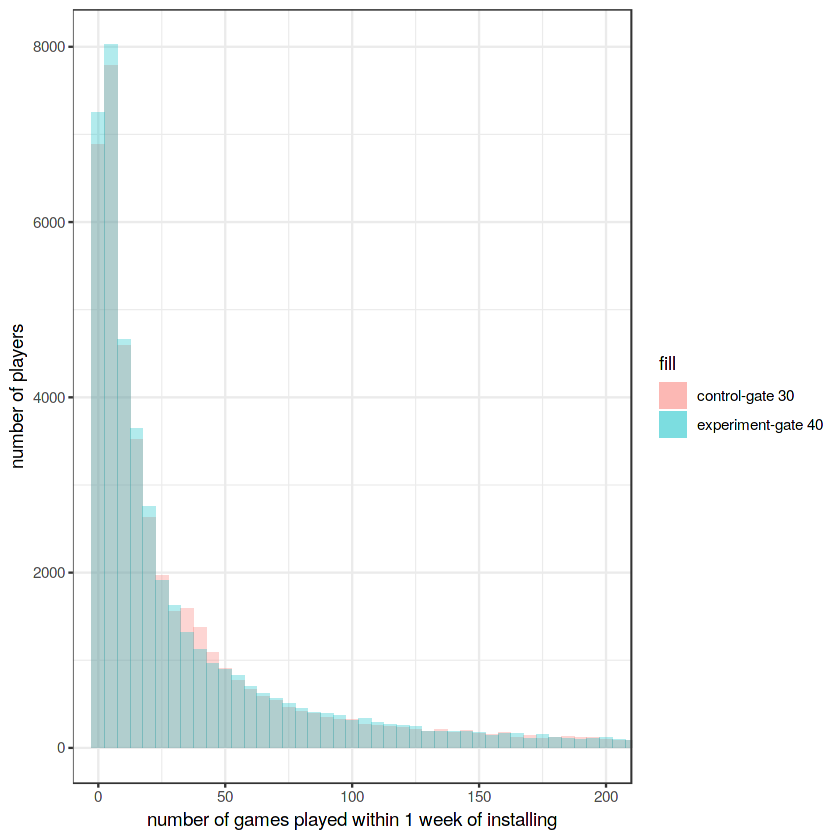

In [113]:
df_con <- subset(df, version == 'gate_30') # the control group
df_exp <- subset(df, version == 'gate_40') # the experiment group

ggplot() + 
geom_histogram(aes(x = df_con$sum_gamerounds, fill = 'control-gate 30'), alpha = 0.3, binwidth = 5) +
geom_histogram(aes(x = df_exp$sum_gamerounds, fill = 'experiment-gate 40'), alpha = 0.3, binwidth = 5) +
coord_cartesian(xlim = c(0,200)) +
theme_bw() +
xlab('number of games played within 1 week of installing') +
ylab('number of players')

The figure above shows that the distributions of total number of games played within the first week of installing the game between the control and the experiment group almost overlap, which is expected since the placing of the first gate shouldn't affect the overall playability of the game. 

However, the slightly higher peak for the experiment group at the left of the figure and the sneaking red color towards 50 rounds imply that there are still differences in the amount of rounds users play between the 2 groups, and it is possible that players in the experiment group where the first gate is placed further back in the game quit the game more quickly than players in the control group. 

In order to test this idea, one way is to fit the data to an exponential distribution which describes how long it takes for an event (in this case, giving up the game) to happen. But conceptually, this distribution does not make perfect sense, since the probability of giving up would not be the same across each round.

So another method is to use nonparametric methods to test if these two distributions are the same. But this requires other metrics to be proposed (potentially estimated using the empirical cumulative distribution function) regarding these two distributions.

Otherwise other metrics should be used to characterize user retention. This will be discussed further in the conclusion in Section 5.

### 2.2.2 Proportion of user retention after the 1st and 7th day

In [114]:
cat('the proportion of users who come back on the 1st and 7th day between groups')
df_retention_prop <- df %>% group_by(version) %>% 
summarise(prop_retention_1 = mean(retention_1),
          prop_retention_7 = mean(retention_7)) 
df_retention_prop

the proportion of users who come back on the 1st and 7th day between groups

version,prop_retention_1,prop_retention_7
<chr>,<dbl>,<dbl>
gate_30,0.4481879,0.1902013
gate_40,0.4422827,0.1820000


# 3. Examining the experiment design

## 3.1 Checking the sample sizes of the experiment

This is an extra step to ensure the validity of the experiment. For each evaluation metric, I'd like to check how large the sample sizes should be to ensure enough power for the test.

Due to the lack of information, parameters such as the significant level, power of test, level of practical significance are assumed for the calculation of sample sizes. 
The calculation will base on numbers from the control group. 

$$\alpha = 0.05$$ 
$$\beta = 0.2$$  
$$d_{min} = 0.01$$  
$$H_0: p_a - p_0 = 0$$  
$$H_a: p_a - p_0 = d_{min} = 0.01$$

In [115]:
alpha <- 0.05
beta <- 0.2
d_min <- 0.01

### 3.1.1 retention after 1 day  
$$p_0 = 0.4482$$
$$p_a = 0.0582$$

In [116]:
p_0_retention_1 <- subset(df_retention_prop, version == 'gate_30')$prop_retention_1
p_a_retention_1 <- p_0_retention_1 + d_min
power.prop.test(p1=p_0_retention_1, p2=p_a_retention_1, 
                sig.level=alpha, power=1-beta, 
                alternative='two.sided')


     Two-sample comparison of proportions power calculation 

              n = 38899.22
             p1 = 0.4481879
             p2 = 0.4581879
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


*side note*  
Comparison between different ways of calculating the sample sizes (of a *two-sided* two-sample test for proportions):  
1. The result is based on the [R function](https://stat.ethz.ch/R-manual/R-devel/library/stats/html/power.prop.test.html) for determining sample sizes or power for two-sample test for proportions. The actual formula is:  
$$n = [\frac{Z_{\frac{\alpha}{2}}\sqrt{2\frac{p_1+p_2}{2}\frac{q_1+q_2}{2}}+Z_\beta\sqrt{p_1q_1+p_2q_2}}{p_2-p_1}]^2$$

In [117]:
z_half_alpha <- qnorm(1-alpha/2)
z_beta <- qnorm(1-beta)
p1 <- p_0_retention_1; p2 <- p_a_retention_1
q1 <- 1-p1; q2 <- 1-p2
n1 <- ((z_half_alpha*sqrt((p1+p2)*(q1+q2)/2)+z_beta*sqrt(p1*q1+p2*q2))/(p2-p1))^2
cat('n1 =', n1)

n1 = 38899.22

2. Another method as the one used in the [Udacity online course for A/B testing](http://www.evanmiller.org/ab-testing/sample-size.html) follows the formula:  
$$n = [\frac{Z_{\frac{\alpha}{2}}\sqrt{2p_1q_1}+Z_\beta\sqrt{p_1q_1+p_2q_2}}{p_2-p_1}]^2$$

In [118]:
n2 <- ((z_half_alpha*sqrt(2*p1*q1)+z_beta*sqrt(p1*q1+p2*q2))/(p2-p1))^2
cat('n2 =', n2)

n2 = 38845.06

3. A third method follows from the textbook calculation of power and sample sizes:  
$$n = \frac{(Z_\frac{\alpha}{2}+Z_\beta)^2(\sigma_1^2+\sigma_2^2)}{(p_2-p_1)^2} = \frac{(Z_\frac{\alpha}{2}+Z_\beta)^2(p_1q_1+p_2q_2)}{(p_2-p_1)^2}$$

In [119]:
n3 <- (z_half_alpha + z_beta)^2*(p1*q1+p2*q2)/((p2-p1)^2)
cat('n3 =', n3)

n3 = 38896.48

Results show that all 3 methods of calculating sample sizes are comparable to each other. If we are being very conservative, then the maximum value out of the 3 results should be applicable.

### 3.1.2 retention after 7 days  
$$p_0 = 0.1902$$  
$$p_a = 0.2002$$

In [120]:
p_0_retention_7 <- subset(df_retention_prop, version == 'gate_30')$prop_retention_7
p_a_retention_7 <- p_0_retention_7 + d_min
power.prop.test(p1=p_0_retention_7, p2=p_a_retention_7, 
                sig.level=alpha, power=1-beta, alternative='two.sided')


     Two-sample comparison of proportions power calculation 

              n = 24659.65
             p1 = 0.1902013
             p2 = 0.2002013
      sig.level = 0.05
          power = 0.8
    alternative = two.sided

NOTE: n is number in *each* group


Compare these results to the summary of the dataset in Section 2.1. The actual number of users in each group is well above the sample size required for each variable.

# 4. Analysis of results

## 4.1 Hypothesis Testing for differences in retention between the 2 groups
Given the large amount of samples, two-sample two-sided Z-tests are used for comparison between the proportions of retention after 1 and 7 days, with the following procedures:

$$H_0: p_{con} - p_{exp} = 0$$
$$H_a: p_{con} - p_{exp} \neq 0$$
$$Z = \frac{\hat{p}_{con} - \hat{p}_{exp} - 0}{S_{pool}}$$
$$\hat{p}_{pool} = \frac{y_{con}+y_{exp}}{n_{con}+n_{exp}}$$ $$S_{pool}=\sqrt(\hat{p}_{pool}(1-\hat{p}_{pool})(\frac{1}{n_{con}}+\frac{1}{n_{exp}}))$$

### 4.1.1 retention after 1 day

In [121]:
df_retention_1_tab <- df %>% group_by(version) %>% 
summarise(count_true = sum(retention_1),
          n = n())
df_retention_1_tab
retention_1_test <- prop.test(df_retention_1_tab$count_true, df_retention_1_tab$n, correct=FALSE)
cat('proportions of 1-day retention for gate at level 30:', round(retention_1_test$estimate[1], 4), '\n')
cat('proportions of 1-day retention for gate at level 40:', round(retention_1_test$estimate[2], 4), '\n')
cat('p-value =', round(retention_1_test$p.value, 4), '\n')
cat('margin of error =', round((retention_1_test$conf.int[2] - retention_1_test$conf.int[1])/2,4), '\n')
cat('95% CI for the difference between conditions:', round(retention_1_test$conf.int, 4))

version,count_true,n
<chr>,<int>,<int>
gate_30,20034,44700
gate_40,20119,45489


proportions of 1-day retention for gate at level 30: 0.4482 
proportions of 1-day retention for gate at level 40: 0.4423 
p-value = 0.0744 
margin of error = 0.0065 
95% CI for the difference between conditions: -6e-04 0.0124

### 4.1.2 retention after 7 days

In [122]:
df_retention_7_tab <- df %>% group_by(version) %>% 
summarise(count_true = sum(retention_7),
          n = n())
df_retention_7_tab
retention_7_test <- prop.test(df_retention_7_tab$count_true, df_retention_7_tab$n, correct=FALSE)
cat('proportions of 7-day retention for gate at level 30:', round(retention_7_test$estimate[1], 4), '\n')
cat('proportions of 7-day retention for gate at level 40:', round(retention_7_test$estimate[2], 4), '\n')
cat('p-value =', round(retention_7_test$p.value, 4), '\n')
cat('margin of error =', round((retention_7_test$conf.int[2] - retention_7_test$conf.int[1])/2,4), '\n')
cat('95% CI for the difference between conditions:', round(retention_7_test$conf.int, 4))

version,count_true,n
<chr>,<int>,<int>
gate_30,8502,44700
gate_40,8279,45489


proportions of 7-day retention for gate at level 30: 0.1902 
proportions of 7-day retention for gate at level 40: 0.182 
p-value = 0.0016 
margin of error = 0.0051 
95% CI for the difference between conditions: 0.0031 0.0133

### 4.1.3 Discussion
Tests in this section show that with a significance level of 0.05, 1-day retention is marginally lower when the gate is at level 40 than at level 30, while 7-day retention is statistically significantly lower when the gate is at level 40. Despite the evidence supporting that retention is worse at level 40, the 95% confidence show that the difference is rather minimal, with margins of error at 0.65% and 0.51% respectively for 1-day and 7-day retention. If the practical level of significance is set at 1%, it would mean that neither of these variables have been affected by the change to the extent that this decrease in retention is alarming for the purpose of keeping users in the game. On the other hand, if any decrease in user retention is to be avoided, then keeping the gate at level 30 instead of moving it to level 40 is definitely recommended.

## 4.2 Nonparametric methods for testing differences in retention between the 2 groups
This section explores some nonparametric methods for estimation to see if results are comparable to results from the parametric hypothesis testing in Section 4.1.  
Similar to the previous sections, hypotheses are still the following:
$$H_0: p_{con} - p_{exp} = 0$$
$$H_a: p_{con} - p_{exp} \neq 0$$

### 4.2.1 Bootstrapping differences in retention
We can sample with replacement from the current samples and get distributions of differences in proportions (in this case the mean of a Bernoulli distribution) of 1-day and 7-day player retention between the 2 groups to see how the 2 groups really differ as per these metrics.
The number of bootstrap samples (1,000) taken are not as high as would be satisfactory due to presentation purposes

* 1-day retention

In [123]:
library(infer)
rep_times <- 1000
diff_mean_retention_1_boot <- df %>% 
mutate(version = factor(version), retention_1 = as.numeric(retention_1)) %>%
specify(retention_1 ~ version) %>%
generate(reps = rep_times, type = 'bootstrap') %>%
calculate(stat = "diff in means", order = c("gate_30", "gate_40"))

proportion of differences in mean that are below 0 in the bootstrap samples: 0.051 
p-value for the two-sided test = 0.102

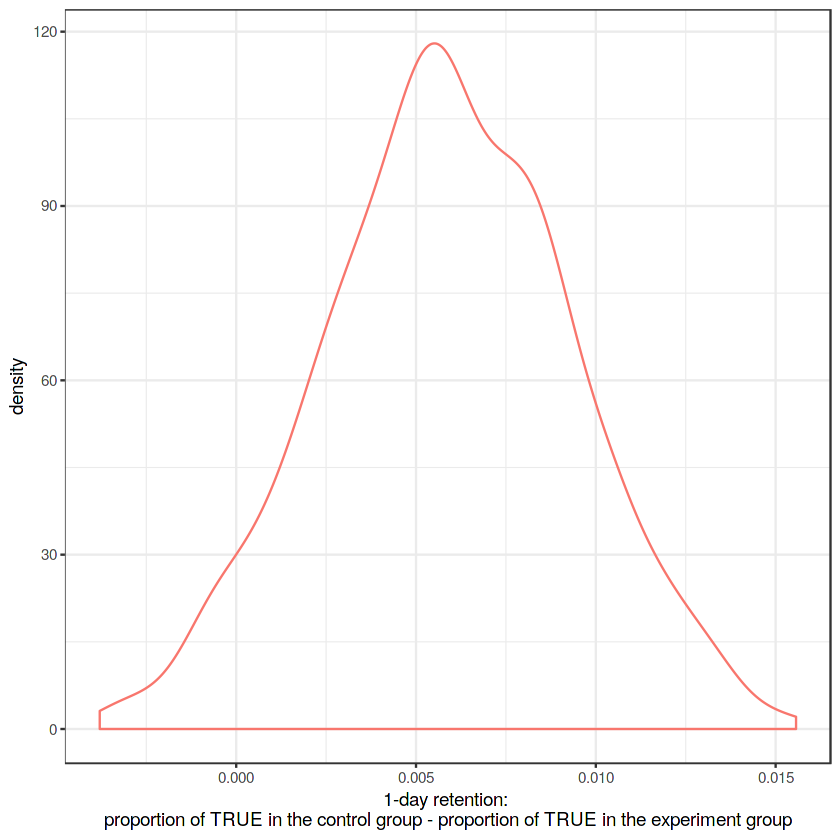

In [124]:
ggplot(diff_mean_retention_1_boot) + 
geom_density(aes(x = stat), color = '#F8766D') + 
theme_bw() +
xlab('1-day retention: \nproportion of TRUE in the control group - proportion of TRUE in the experiment group')

cat('proportion of differences in mean that are below 0 in the bootstrap samples:', (prop_below0 <- diff_mean_retention_1_boot %>% 
filter(stat <= 0) %>%
summarise(n()/rep_times) %>% pull()), '\n')
cat('p-value for the two-sided test =', 2*prop_below0)

* 7-day retention

In [125]:
diff_mean_retention_7_boot <- df %>% 
mutate(version = factor(version), retention_7 = as.numeric(retention_7)) %>%
specify(retention_7 ~ version) %>%
generate(reps = rep_times, type = 'bootstrap') %>%
calculate(stat = "diff in means", order = c("gate_30", "gate_40"))

proportion of differences in mean that are below 0 in the bootstrap samples: 0 
p-value for the two-sided test = 0

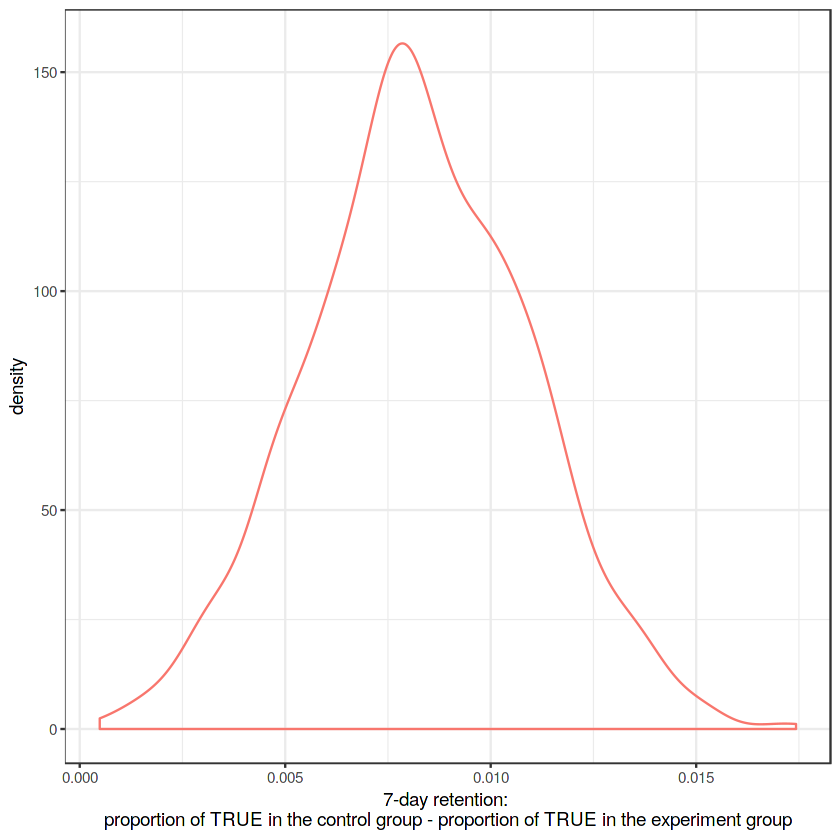

In [126]:
ggplot(diff_mean_retention_7_boot) + 
geom_density(aes(x = stat), color = '#F8766D') + 
theme_bw() +
xlab('7-day retention: \nproportion of TRUE in the control group - proportion of TRUE in the experiment group')

cat('proportion of differences in mean that are below 0 in the bootstrap samples:', (prop_below0 <- diff_mean_retention_7_boot %>% 
filter(stat <= 0) %>%
summarise(n()/rep_times) %>% pull()), '\n')
cat('p-value for the two-sided test =', 2*prop_below0)

Results from bootstrapping for difference in sample means for both 1-day and 7-day retention led to similar p-values. From bootstrapping results, it can be seen that in less than 4% of samples, gate at level 40 has the same or better 1-retention than the control group where the gate is at level 30. For 7-day retention, this proportion is less than 1%. In other words, bootstrapping results reveal that in the majority of cases, moving the gate from level 30 to 40 decreases player retention. 

### 4.2.2 Permutation test

Apart from bootstrapping, we can reassign labels in samples to compare if proportions for 1-day and 7-day retention really differ.  
$H_0:$ there is no difference between the 2 groups, samples for retention were taken from the same distribution for both groups.  
$H_a:$ samples were not taken from the same distribution, the 2 groups differ from each other.
* 1-day retention

In [127]:
rep_times <- 1000
n_con <- nrow(df_con)
n_exp <- nrow(df_exp)
sum_retention_1 <- sum(df$retention_1)
con_mean_retention_1_perm <- replicate(rep_times, mean(sample(df$retention_1, n_con, replace = FALSE)))
exp_mean_retention_1_perm <- (sum_retention_1 - con_mean_retention_1_perm*n_con)/n_exp
diff_mean_retention_1_perm <- con_mean_retention_1_perm - exp_mean_retention_1_perm

quantile of observed difference in proportion of 1-day retention in permutation samples: 96.3%
p-value for the two-sided test = 0.074

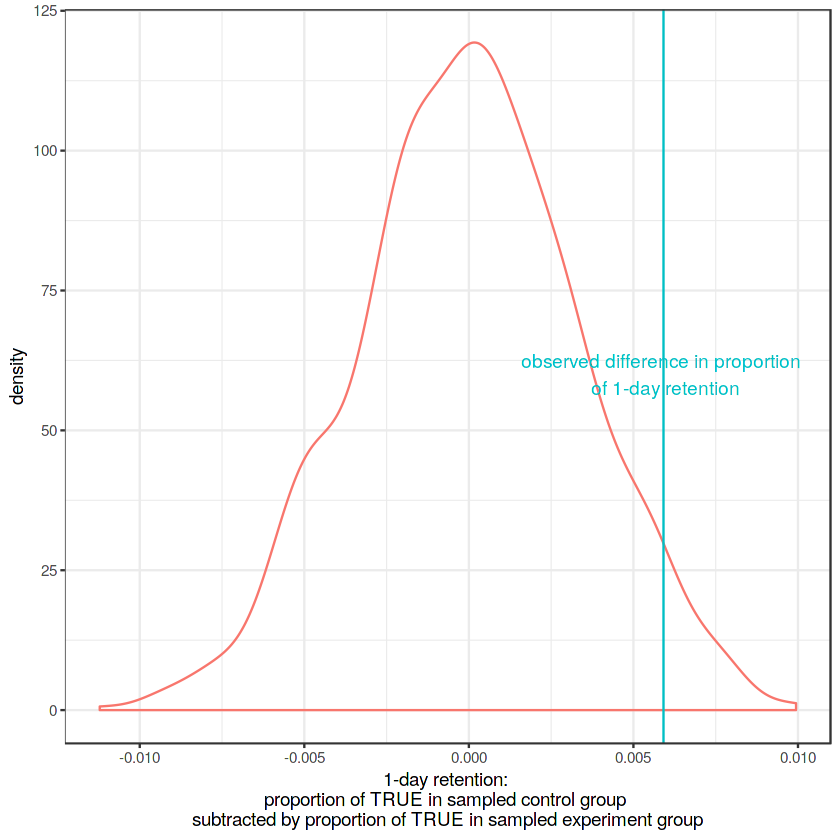

In [128]:
diff_mean_retention_1_obs <- mean(df_con$retention_1) - mean(df_exp$retention_1)
ggplot() + 
geom_density(aes(x = diff_mean_retention_1_perm), color = '#F8766D') + 
theme_bw() + geom_vline(xintercept = diff_mean_retention_1_obs, color = '#00BFC4') +
xlab('1-day retention: \nproportion of TRUE in sampled control group \nsubtracted by proportion of TRUE in sampled experiment group') +
geom_text(aes(x=diff_mean_retention_1_obs, y = 60, label="observed difference in proportion \n of 1-day retention"), color = '#00BFC4')

diff_mean_retention_1_perm_ecdf <- ecdf(diff_mean_retention_1_perm)
cat('quantile of observed difference in proportion of 1-day retention in permutation samples:', 
    paste0(diff_mean_retention_1_perm_ecdf(diff_mean_retention_1_obs)*100, '%\n'))
cat('p-value for the two-sided test =', 2*(1-diff_mean_retention_1_perm_ecdf(diff_mean_retention_1_obs)))

* 7-day retention

In [129]:
sum_retention_7 <- sum(df$retention_7)
con_mean_retention_7_perm <- replicate(rep_times, mean(sample(df$retention_7, n_con, replace = FALSE)))
exp_mean_retention_7_perm <- (sum_retention_7 - con_mean_retention_7_perm*n_con)/n_exp
diff_mean_retention_7_perm <- con_mean_retention_7_perm - exp_mean_retention_7_perm

quantile of observed difference in proportion of 7-day retention in permutation samples: 99.8%
p-value for the two-sided test = 0.004

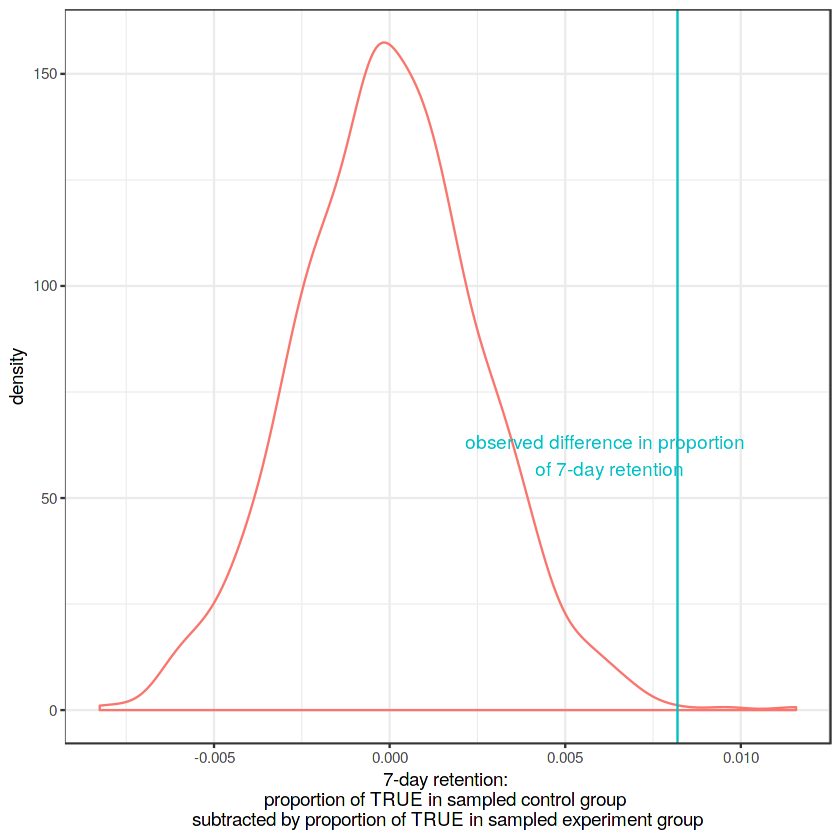

In [130]:
diff_mean_retention_7_obs <- mean(df_con$retention_7) - mean(df_exp$retention_7)
ggplot() + 
geom_density(aes(x = diff_mean_retention_7_perm), color = '#F8766D') + 
theme_bw() + geom_vline(xintercept = diff_mean_retention_7_obs, color = '#00BFC4') +
xlab('7-day retention: \nproportion of TRUE in sampled control group \nsubtracted by proportion of TRUE in sampled experiment group') +
geom_text(aes(x=diff_mean_retention_7_obs-0.002, y = 60, label="observed difference in proportion \n of 7-day retention"), color = '#00BFC4')

diff_mean_retention_7_perm_ecdf <- ecdf(diff_mean_retention_7_perm)
cat('quantile of observed difference in proportion of 7-day retention in permutation samples:', 
    paste0(diff_mean_retention_7_perm_ecdf(diff_mean_retention_7_obs)*100, '%\n'))
cat('p-value for the two-sided test =', 2*(1-diff_mean_retention_7_perm_ecdf(diff_mean_retention_7_obs)))

# 5. Conclusion

## 5.1 Decision given the available data

All results from parametric hypothesis testing and non-parametric bootstrapping as well as permutation test lead to the conclusion that 7-day retention is significantly worse for the group getting the gate at level 40, and the decreas in 1-day retention is marginally significant. However, as discussed in Section 4.1.3, the effect sizes are very minimal, so it will depend on setting up a practical significant level to know how much weight should actually be put on interpreting this decrease in user retention in the experiment condition.

Overall, if we are going to make the decision based purely on the available metrics and statistical level of significance, moving the first gate from level 30 to 40 is definitely not recommended.

## 5.2 Other metrics to be considered

The important question is what the ultimate goal is for choosing where to put the first gate. If the goal is simply to boost user retention, then this move does not seem like a good idea since both 1-day and 7-day retention decrease compared to keeping the status quo. However, another possible goal for trying to make this choice would be to boost in-app purchases. Therefore, it is important to see that end of the story as well. If there is significant increase in that regard, then the rather slight decrease in user retention as shown here would instead indicate that it would be safe to move the first gate back. This is not an implausible idea to suggest, since if the player gets 10 more levels before he is forced to pause, the increase in sunk cost might incentivize him to make a purchase.

If our single goal is to test user retention, there are other metrics to be considered as well. As already discussed in Section 2.2.1, more analysis can go into the distribution of number of rounds between the two group. 